In [57]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')
train_file = '/work/data/splits/splits_0.050/train.json'
val_file = '/work/data/splits/splits_0.050/val.json'
test_file = '/work/data/splits/splits_0.050/test.json'
tp_str = 'tp_const'
train_dataloader, val_dataloader, test_dataloader = extract_data(train_file, val_file, test_file, community_no=100, batch_size = 50, 
                                                                 verbose=True,  is_run_clust=True, clust_verbose=False
                                                                , TP_graph_type=tp_str)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

In [71]:
def get_relation_types(dataloader):
    edge_lst, lbs = [], []
    for batch_no,(batched_graph, labels) in enumerate(dataloader):
        edge_types = batched_graph.edata['rel_type']
        edge_lst.extend(edge_types.tolist())
        label_lst = labels.tolist()
        label_str = ''
        for x in label_lst:
            lbs.append( str(x))
    return edge_lst, lbs
train_edge,train_gt = get_relation_types(train_dataloader)
val_edge,val_gt = get_relation_types(val_dataloader)
test_edge,test_gt = get_relation_types(test_dataloader)
    

In [72]:
from collections import Counter
def gt_dist(lst):
    dct = {}
    for x in lst:
        if x not in dct.keys():
            dct[x] = 1
        else:
            dct[x] +=1
    for i in dct.keys():
        print(f'For {i}, we have {dct[i]}')
print('Train\n')
gt_dist(train_gt)
print('Val\n')
gt_dist(val_gt)
print('Test\n')
gt_dist(test_gt)

Train

For [0.0, 1.0], we have 137
For [1.0, 0.0], we have 149
Val

For [1.0, 0.0], we have 39
For [0.0, 1.0], we have 57
Test

For [1.0, 0.0], we have 51
For [0.0, 1.0], we have 45


In [18]:
print(len(train_edge), len(val_edge), len(test_edge))

2023 644 616


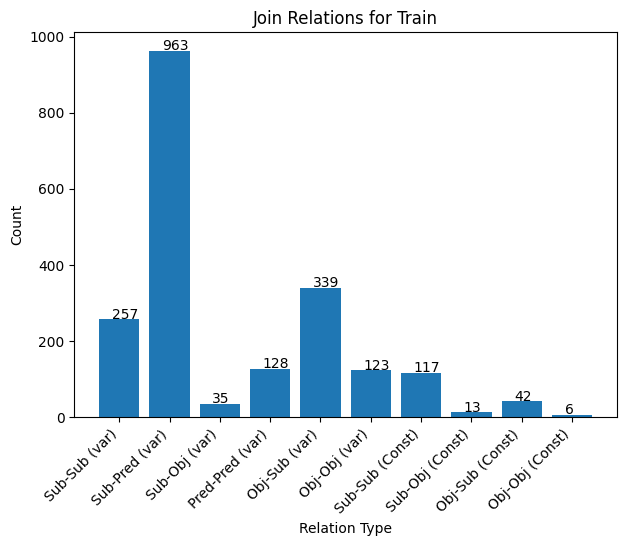

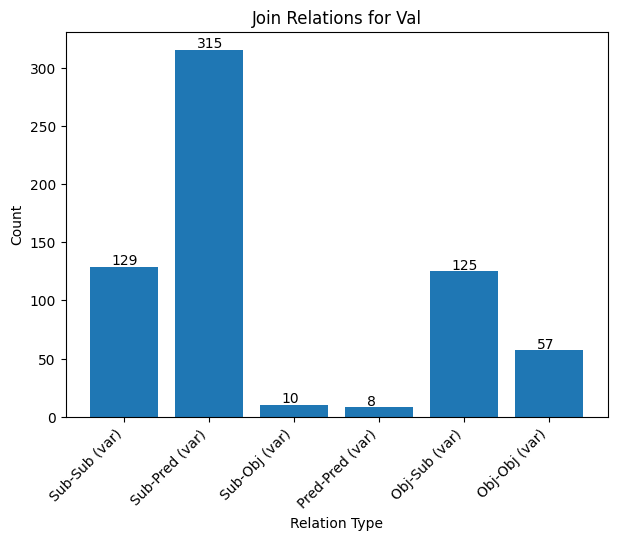

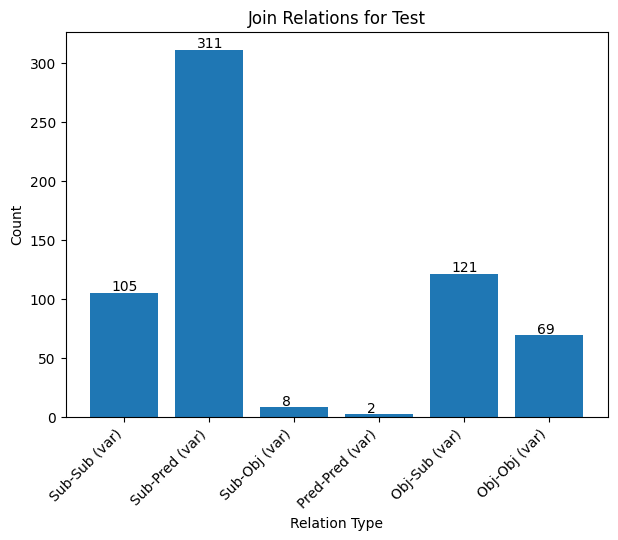

In [55]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_rel_types(lst, title):
    lst = sorted(lst)
    dct = {
        0: 'Sub-Sub (var)',
        1: 'Sub-Pred (var)',
        2: 'Sub-Obj (var)',
        
        3: 'Pred-Sub (var)',
        4: 'Pred-Pred (var)',
        5: 'Pred-Obj (var)',
        
        6: 'Obj-Sub (var)',
        7: 'Obj-Pred (var)',
        8: 'Obj-Obj (var)',
        
        9: 'Sub-Sub (Const)',
        10: 'Sub-Pred (Const)',
        11: 'Sub-Obj (Const)',
        
        12: 'Pred-Sub (Const)',
        13: 'Pred-Pred (Const)',
        14: 'Pred-Obj (Consts)',
        
        15: 'Obj-Sub (Const)',
        16: 'Obj-Pred (Const)',
        17: 'Obj-Obj (Const)',
    }
    plt.figure(figsize=(7, 5))
    counts = Counter(lst)
    x = list(counts.keys())
    #x = [str(i) for i in x]
    x = [dct[i] for i in x]
    y = list(counts.values())
    plt.bar(x, y)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Relation Type')
    plt.ylabel('Count')

    for i, v in enumerate(y):
        plt.text(i-0.15, v + 2, str(v))
    plt.title(title)
    plt.show()
plot_rel_types(train_edge, 'Join Relations for Train')
plot_rel_types(val_edge, 'Join Relations for Val')
plot_rel_types(test_edge, 'Join Relations for Test')